In [ ]:
packages<-c("rugarch", "fGarch", "forecast", "tseries", "aTSA", "readr", "psych", "ggfortify",
            "quantmod","rugarch","FitAR","tseries","FinTS","TSA","forecast","fGarch")


package.check = lapply(packages, FUN = function(x){
     if (!require(x, character.only = TRUE)) {
          install.packages(x, dependencies = TRUE)
          library(x, character.only = TRUE)
     }
}
)

Loading required package: rugarch

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rugarch’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘nloptr’, ‘ks’, ‘numDeriv’, ‘spd’, ‘xts’, ‘zoo’, ‘chron’, ‘SkewHyperbolic’, ‘RcppArmadillo’


Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma


Loading required package: fGarch

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘fGarch’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gss’, ‘stabledist’, ‘timeDate’, ‘timeSeries’, ‘fBasics’, ‘fastICA’

# Serie de Tiempo: **Apertura de TESLA

Autores:
- Brian Granados
- Juan Osorio
- David Romero
- Allan Ramirez

La acción de la empresa TESLA comenzó a cotizar en Estados Unidos desde mediados de 2010 y se destaca por un **boom que ocurre a finales de 2019** en el cuál la acción pasó a valer más de 400 USD. Y a pesar de la emergencia provocada por el Covid 19 la serie alcanzó su punto máximo histórico en el primer trimestre de 2020.

Hacemos la carga de información

In [ ]:
data = read.csv('TSLA.csv',header = T)

In [ ]:
str(data)

'data.frame':	2487 obs. of  7 variables:
 $ Date     : chr  "2011-01-03" "2011-01-04" "2011-01-05" "2011-01-06" ...
 $ Open     : num  5.37 5.33 5.3 5.37 5.6 ...
 $ High     : num  5.4 5.39 5.38 5.6 5.72 ...
 $ Low      : num  5.18 5.2 5.24 5.36 5.58 ...
 $ Close    : num  5.32 5.33 5.37 5.58 5.65 ...
 $ Adj.Close: num  5.32 5.33 5.37 5.58 5.65 ...
 $ Volume   : int  6415000 5937000 7233500 10306000 11239500 6713500 8551000 4822000 3618000 5960000 ...


Seleccionamos la **apertura de la serie**

In [ ]:
tesla.ts <- xts(data$Open[1:1990], order.by=as.Date(data$Date[1:1990]))

Hacemos un **gráfico** de la serie

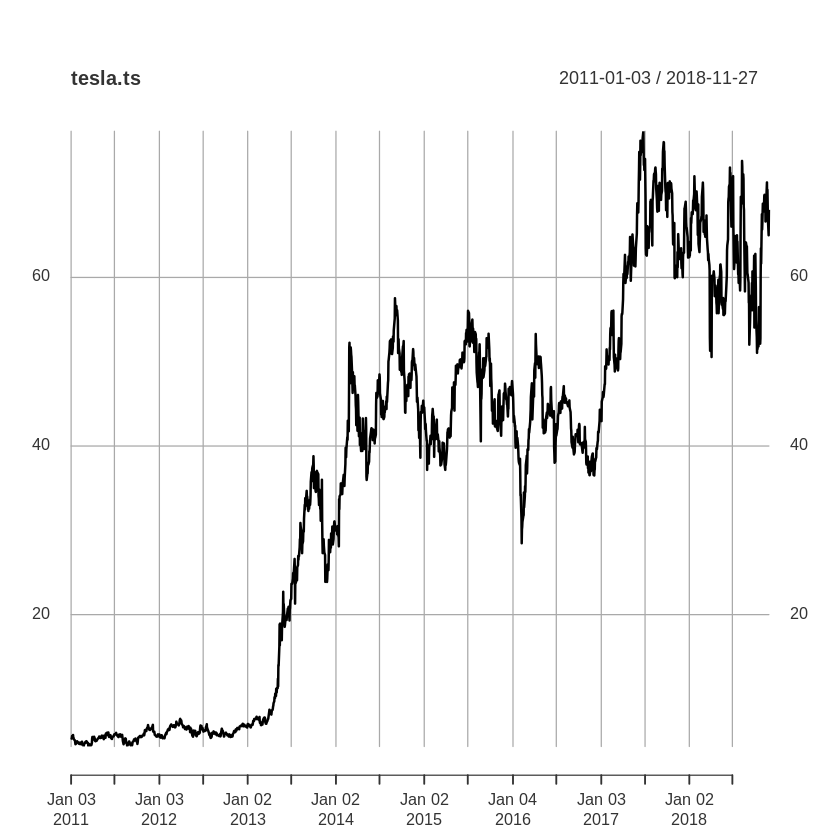

In [ ]:
plot(tesla.ts)

Graficamos la **ACF** para ver si existe una estructura de autocorrelación

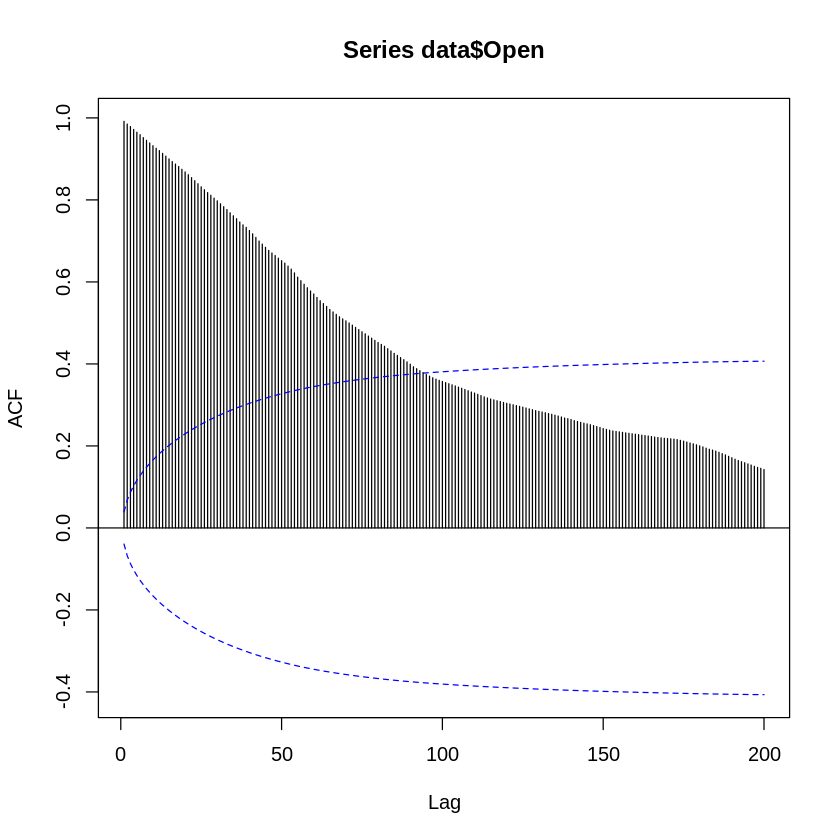

In [ ]:
acf(data$Open, lag.max = 200, ci.type='ma')

Calculamos los retornos de la serie de apertura para estabilizar la varianza 

$$
r_t = log\left(\frac{X_{t+1}}{X_t}\right)
$$

In [ ]:
sretornos = dailyReturn(tesla.ts)
head(sretornos)

           daily.returns
2011-01-03   0.000000000
2011-01-04  -0.006706408
2011-01-05  -0.006751688
2011-01-06   0.013217523
2011-01-07   0.043607902
2011-01-10   0.006071429

Graficamos la serie de **retornos**

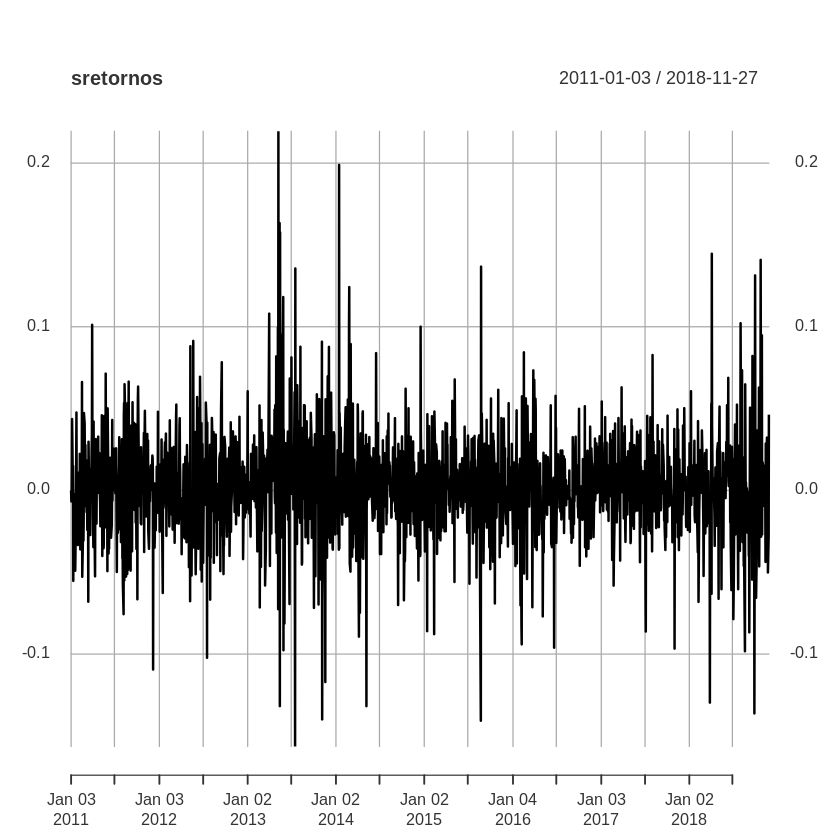

In [ ]:
plot(sretornos)

De aquí que podamos identificar gráficamente en la serie de retornos la existencia al menos **3 clusters de volatilidad en la serie** que se registran en las siguientes fechas:

- Mediados de 2013
- Inicios de 2016
- A lo largo de 2018

Graficamos las **ACF** y **PACF** para darnos una idea de la autocorrelación de un posible modelo ARMA.

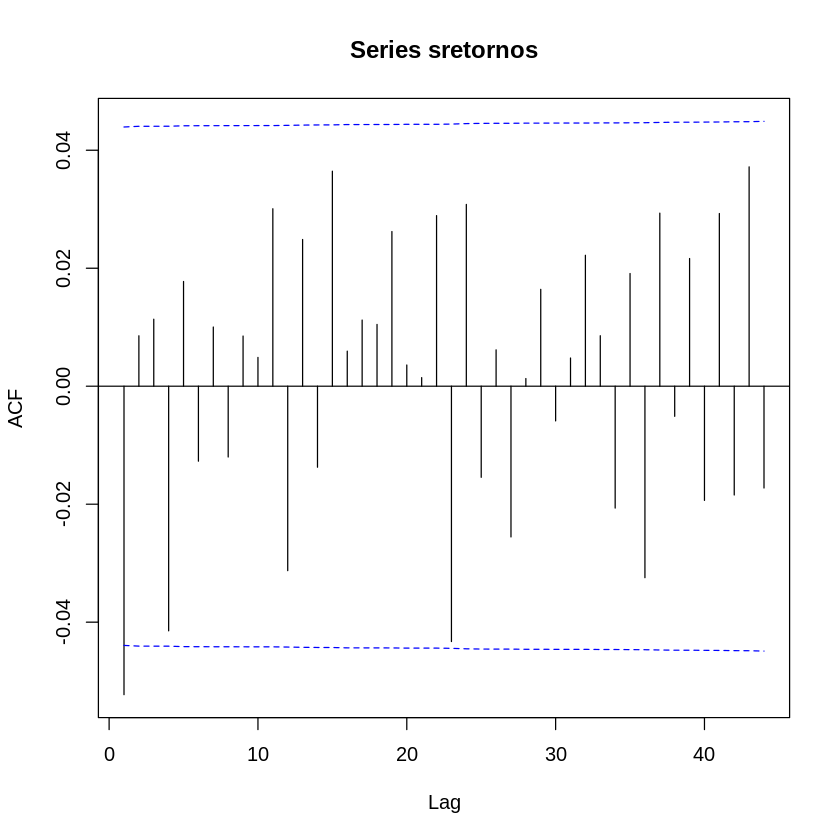

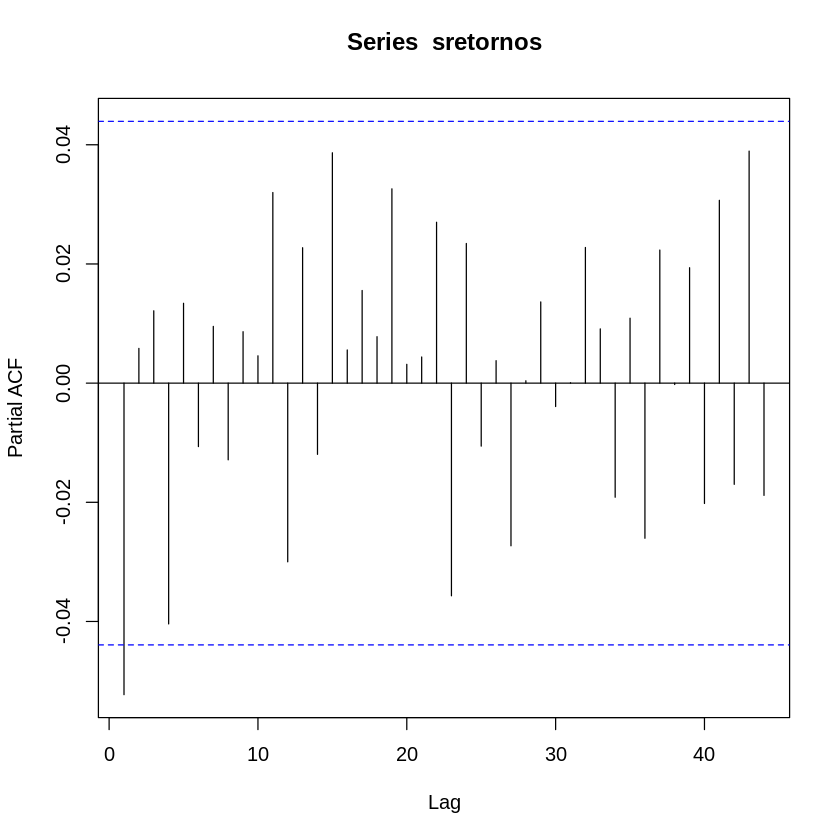

In [ ]:
acf(sretornos,lag.max = 44, ci.type = 'ma')
pacf(sretornos,lag.max = 44)

Observamos si posee correlación serial. **Ho: No correlación serial**.

In [ ]:
Box.test(sretornos,lag=44,type="Ljung")


	Box-Ljung test

data:  sretornos
X-squared = 45.092, df = 44, p-value = 0.426


Como no posee correlación serial se propone un modelo $ARMA(0,0)$ el cuál es equivalente a un modelo de media y podemos proceder a realizar las pruebas de  heteroscedasticidad condicional.

Definimos las **innovaciones** o residuos del modelo $ARMA(0,0)$



In [ ]:
at = sretornos-mean(sretornos)

Se chequea la autocorrelación serial del cuadrado de los residuos

In [ ]:
Box.test(at^2,lag=44,type="Ljung")


	Box-Ljung test

data:  at^2
X-squared = 526.96, df = 44, p-value < 2.2e-16


Rechazamos entonces la hipótesis nula de que no hay efectos heteroscedásticos condicionales. Es decir que tenemos autocorrelación serial del cuadrado de los residuos del modelo $ARMA(0,0)$.

Para asegurar que el modelo de volatilidad es pertinente, se prueba si hay efectos $ARCH$. La prueba de efectos $ARCH$ se basa en multiplicadores de Lagrange para descomponer la varianza de la serie e identificar si sus rezagos son significativos.

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order  PQ p.value
[1,]     4 322       0
[2,]     8 372       0
[3,]    12 422       0
[4,]    16 440       0
[5,]    20 447       0
[6,]    24 448       0
Lagrange-Multiplier test: 
     order   LM p.value
[1,]     4 1528       0
[2,]     8  728       0
[3,]    12  468       0
[4,]    16  349       0
[5,]    20  276       0
[6,]    24  227       0


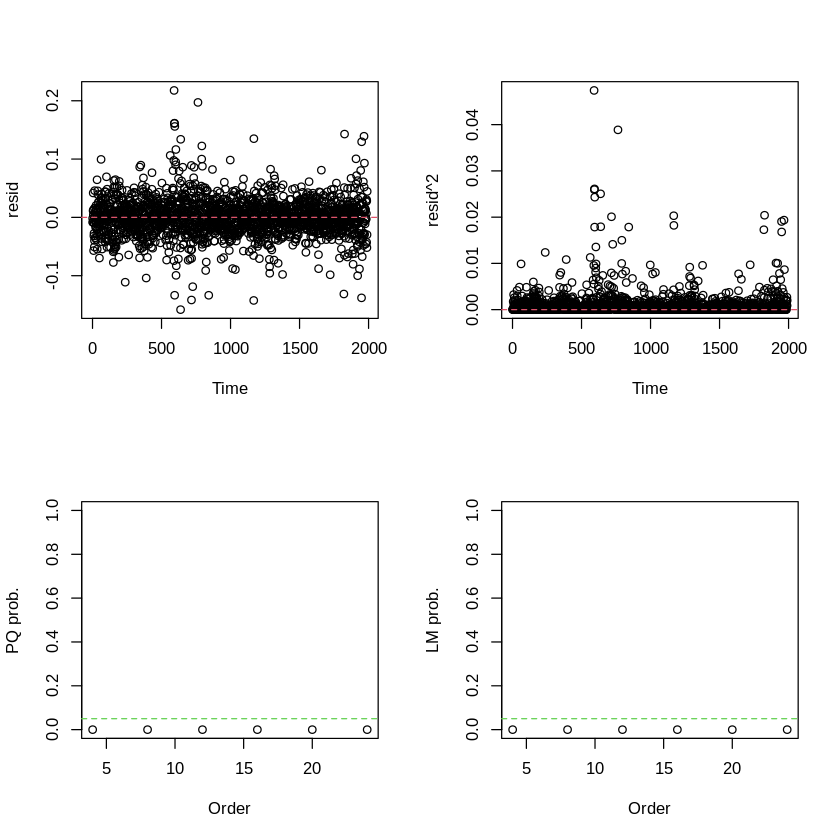

In [ ]:
Model <- arima(sretornos, order=c(0,0,0))
arch.test(Model)

Concluimos la presencia de heterocedasticidad condicional también debido a que en el **test de Portmanteau** se rechaza la hipótesis nula $H_0= \rho_1,\dots,\rho_m$ .

Procedemos a estimar el orden de un modelo ARCH identificando en la **PACF**.

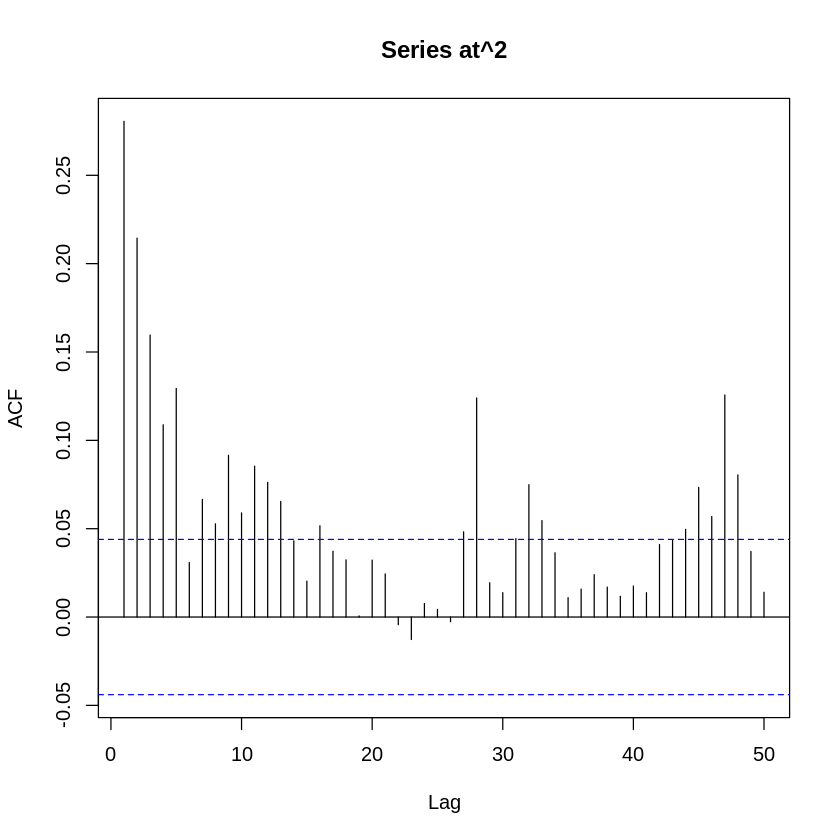

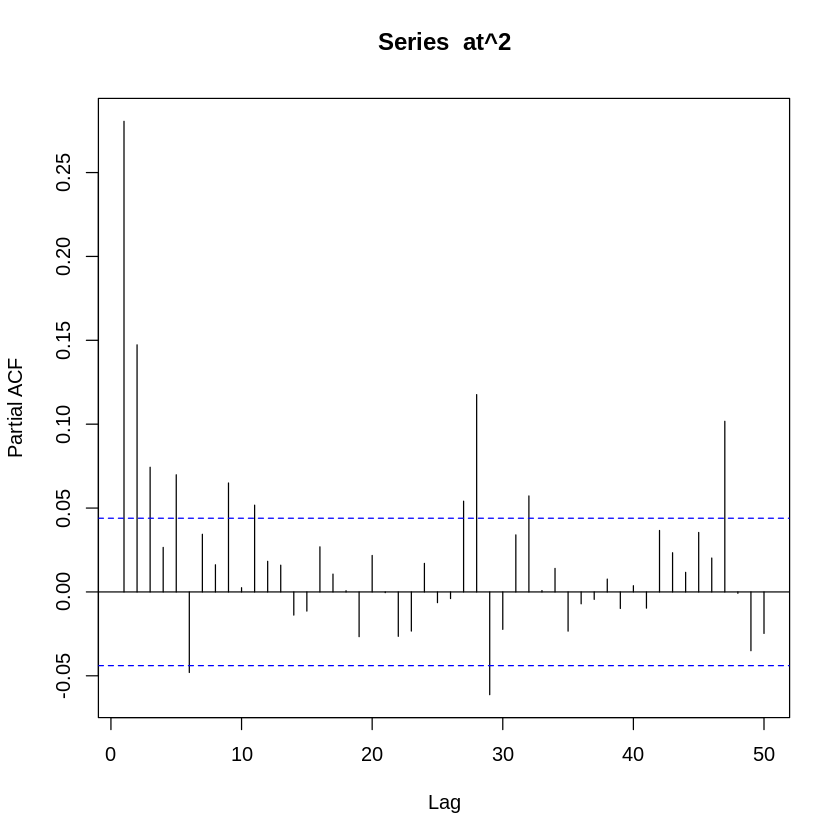

In [ ]:
acf(at^2, lag.max = 50)
pacf(at^2,lag.max = 50)

Con la **PACF** parece que el modelo ARCH(32) es apropiado. Note que el número indica el proceso para la varianza, no para la media como en los modelo ARIMA.

$$
r_{t}=\mu+a_{t}, \quad a_{t}=\sigma_{t} \epsilon_{t}, \quad \sigma_{t}^{2}=\alpha_{0}+\alpha_{1} a_{t-1}^{2}+\cdots+\alpha_{32} a_{t-32}^{2} \qquad \epsilon_t \sim N(0,\eta^2)
$$

Procedemos a realizar el ajuste del modelo mediante la función `garchFit` del paquete `fGarch`.



In [ ]:
m1<-garchFit(sretornos ~ garch(32,0),data=sretornos,trace=F)
summary(m1)

Warning message in sqrt(diag(fit$cvar)):
“NaNs produced”
Warning message:
“Using formula(x) is deprecated when x is a character vector of length > 1.
  Consider formula(paste(x, collapse = " ")) instead.”



Title:
 GARCH Modelling 

Call:
 garchFit(formula = sretornos ~ garch(32, 0), data = sretornos, 
    trace = F) 

Mean and Variance Equation:
 data ~ garch(32, 0)
<environment: 0x56370e79a008>
 [data = sretornos]

Conditional Distribution:
 norm 

Coefficient(s):
        mu       omega      alpha1      alpha2      alpha3      alpha4  
0.00147545  0.00025640  0.22273363  0.06112013  0.02898173  0.01635575  
    alpha5      alpha6      alpha7      alpha8      alpha9     alpha10  
0.01984917  0.00000001  0.00000001  0.00000001  0.04851208  0.00000001  
   alpha11     alpha12     alpha13     alpha14     alpha15     alpha16  
0.00000001  0.00490077  0.00766346  0.00000001  0.00000001  0.00859207  
   alpha17     alpha18     alpha19     alpha20     alpha21     alpha22  
0.02845069  0.03903600  0.00000001  0.01710471  0.04166919  0.00497977  
   alpha23     alpha24     alpha25     alpha26     alpha27     alpha28  
0.00603073  0.00440741  0.00815178  0.00000001  0.05093588  0.06745653  
   al

Observamos un ajuste muy **regular** ya que bastantes parámetros no son significativos. Pero a esto, se toma la recomendación de **Tsay, An Introduction to Analysis of Financial Data with R, Capítulo 4** donde se sugiere el uso de un modelo GARCH cuando el orden del modelo ARCH es grande . 

Procedemos a modelar un **$GARCH(m,s)$** donde el  modelamiento de la heteroscedasticidad ya no depende solo de la volatilidad sino también de su misma de su varianza rezagada.

Para escoger el orden graficamos de nuevo la **PACF**.

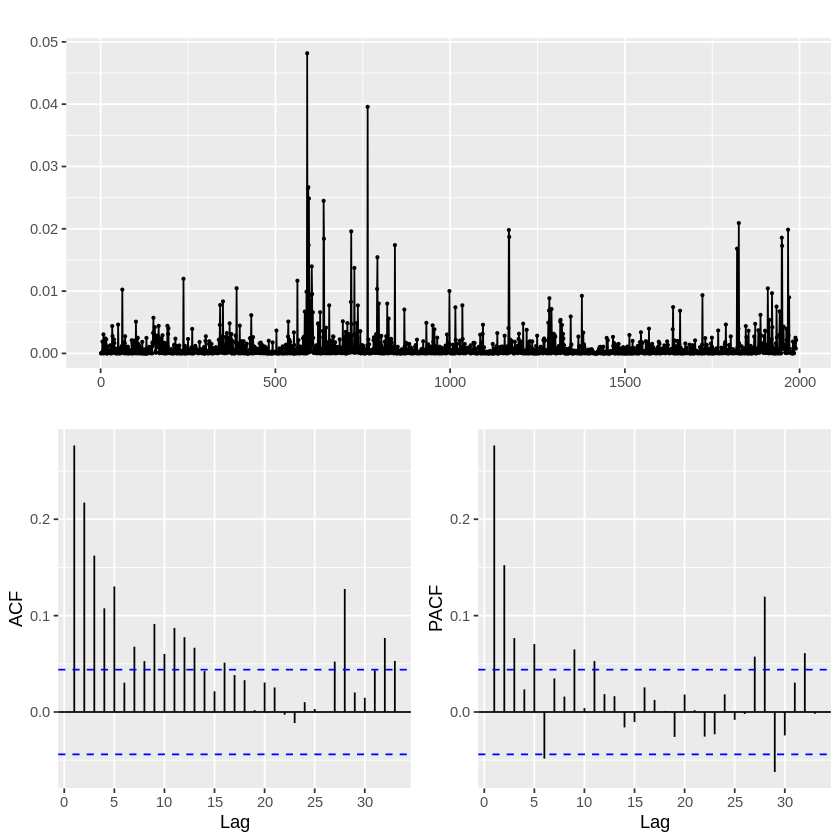

In [ ]:
ggtsdisplay(sretornos^2)

Ajustamos un $GARCH(28,28)$

In [ ]:
garch2828 = ugarchspec(variance.model=list(garchOrder=c(28,28)),mean.model = list(armaOrder=c(0,0)))
garch2828.fit = ugarchfit(spec=garch12,data=sretornos,solver.control = list(trace=1))
garch2828.fit


Iter: 1 fn: -4183.7841	 Pars:  0.00167902 0.00004982 0.11013587 0.13097027 0.70941181
Iter: 2 fn: -4183.7841	 Pars:  0.00167892 0.00004982 0.11013285 0.13096802 0.70942431
solnp--> Completed in 2 iterations



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001679    0.000628   2.6749 0.007476
omega   0.000050    0.000030   1.6781 0.093330
alpha1  0.110133    0.029488   3.7349 0.000188
beta1   0.130968    0.079772   1.6418 0.100638
beta2   0.709424    0.103574   6.8495 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001679    0.000734  2.28695 0.022199
omega   0.000050    0.000134  0.37269 0.709379
alpha1  0.110133    0.131917  0.83487 0.403793
beta1   0.130968    0.148615  0.88126 0.378179
beta2   0.709424    0.385853  1.83859 0.065976

LogLikelihood : 4183.784 

Information Criteria
------------------------------------
                

Ajustamos un $GARCH(2,2)$ 

In [ ]:
garch22 = ugarchspec(variance.model=list(garchOrder=c(2,2)),mean.model = list(armaOrder=c(0,0)))
garch22.fit = ugarchfit(spec=garch22,data=sretornos,solver.control = list(trace=1))
garch22.fit


Iter: 1 fn: -4183.7841	 Pars:  0.00167865097 0.00004980746 0.11012526088 0.00000009763 0.13098867007 0.70942882528
Iter: 2 fn: -4183.7841	 Pars:  0.00167875261 0.00004981106 0.11012416429 0.00000005909 0.13097496899 0.70944154821
solnp--> Completed in 2 iterations



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(2,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001679    0.000630 2.665457 0.007688
omega   0.000050    0.000038 1.319082 0.187142
alpha1  0.110124    0.029921 3.680470 0.000233
alpha2  0.000000    0.039178 0.000002 0.999999
beta1   0.130975    0.260252 0.503262 0.614780
beta2   0.709442    0.217359 3.263918 0.001099

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001679    0.000868  1.93462 0.053037
omega   0.000050    0.000222  0.22464 0.822259
alpha1  0.110124    0.114851  0.95884 0.337638
alpha2  0.000000    0.178724  0.00000 1.000000
beta1   0.130975    1.060646  0.12349 0.901722
beta2   0.709442    0.662422  1.07098 0.284178

LogLike

Ajustamos un $GARCH(1,2)$ 

In [ ]:
garch12 = ugarchspec(variance.model=list(garchOrder=c(1,2)),mean.model = list(armaOrder=c(0,0)))
garch12.fit = ugarchfit(spec=garch12,data=sretornos,solver.control = list(trace=1))
garch12.fit


Iter: 1 fn: -4183.7841	 Pars:  0.00167902 0.00004982 0.11013587 0.13097027 0.70941181
Iter: 2 fn: -4183.7841	 Pars:  0.00167892 0.00004982 0.11013285 0.13096802 0.70942431
solnp--> Completed in 2 iterations



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,2)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001679    0.000628   2.6749 0.007476
omega   0.000050    0.000030   1.6781 0.093330
alpha1  0.110133    0.029488   3.7349 0.000188
beta1   0.130968    0.079772   1.6418 0.100638
beta2   0.709424    0.103574   6.8495 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001679    0.000734  2.28695 0.022199
omega   0.000050    0.000134  0.37269 0.709379
alpha1  0.110133    0.131917  0.83487 0.403793
beta1   0.130968    0.148615  0.88126 0.378179
beta2   0.709424    0.385853  1.83859 0.065976

LogLikelihood : 4183.784 

Information Criteria
------------------------------------
                

Ajustamos un $GARCH(1,1)$ 

In [ ]:
garch11 = ugarchspec(variance.model=list(garchOrder=c(1,1)),mean.model = list(armaOrder=c(0,0)))
garch11.fit = ugarchfit(spec=garch11,data=sretornos,solver.control = list(trace=1))
garch11.fit 


Iter: 1 fn: -4184.1610	 Pars:  0.0018814 0.0002525 0.2125032 0.5324492
Iter: 2 fn: -4184.1610	 Pars:  0.0018814 0.0002525 0.2125032 0.5324492
solnp--> Completed in 2 iterations



*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001881    0.000623   3.0221 0.002510
omega   0.000253    0.000075   3.3479 0.000814
alpha1  0.212503    0.040303   5.2727 0.000000
beta1   0.532449    0.107897   4.9348 0.000001

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001881    0.000707   2.6607 0.007797
omega   0.000253    0.000217   1.1617 0.245352
alpha1  0.212503    0.101214   2.0995 0.035770
beta1   0.532449    0.309254   1.7217 0.085120

LogLikelihood : 4184.161 

Information Criteria
------------------------------------
                    
Akaike       -4.2012
Bayes        -4.1899
Shibata      -4.2012
Hannan-Quinn -4.1970

Weig

Se elige el modelo $GARCH(1,1)$ con el **74.5% de explicacion de volatilidad** 💥 y con todos los parámetros significativos como el mejor modelo para simular la serie de retornos de Tesla apartir de los parametros obtenidos.



$$
a_{t}=\sigma_{t} \epsilon_{t}, \quad \sigma_{t}^{2}=\alpha_{0}+ \alpha_{1} a_{t-1}^{2}+\beta_{1} \sigma_{t-1}^{2}
$$

Ahora hacemos una pequeña lectura de los residuales

In [ ]:
Box.test(residuals(garch11.fit),lag=50,type="Ljung")


	Box-Ljung test

data:  residuals(garch11.fit)
X-squared = 55.8, df = 50, p-value = 0.266


Concluimos por el p valor que no existe autocorrelación serial presente .

Ahora revisamos algunos **gráficos importantes** de los residuales estandarizados 


please wait...calculating quantiles...


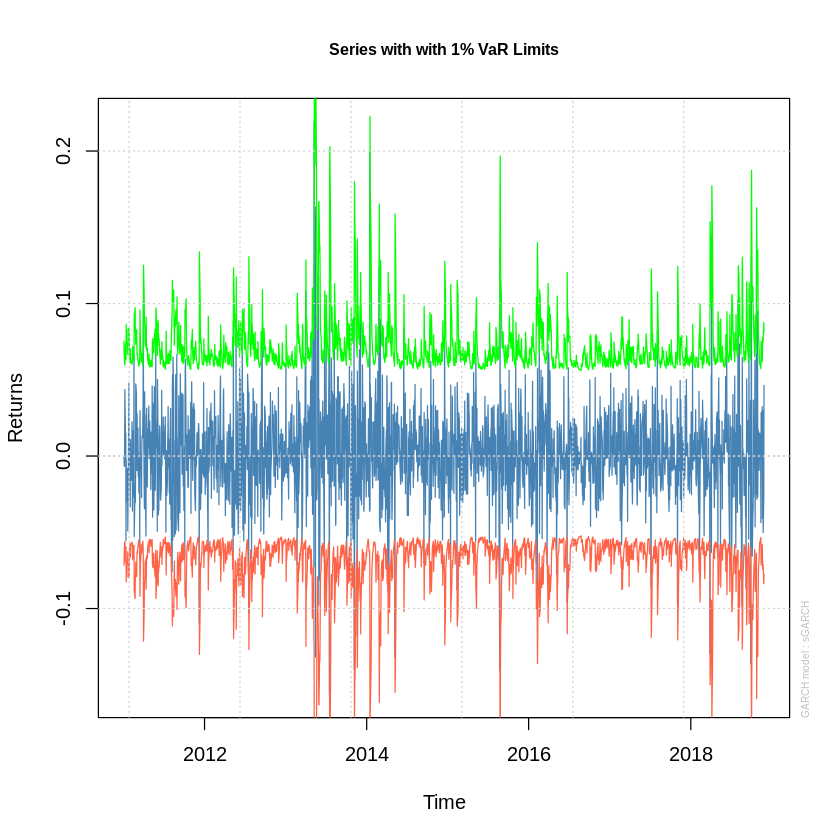

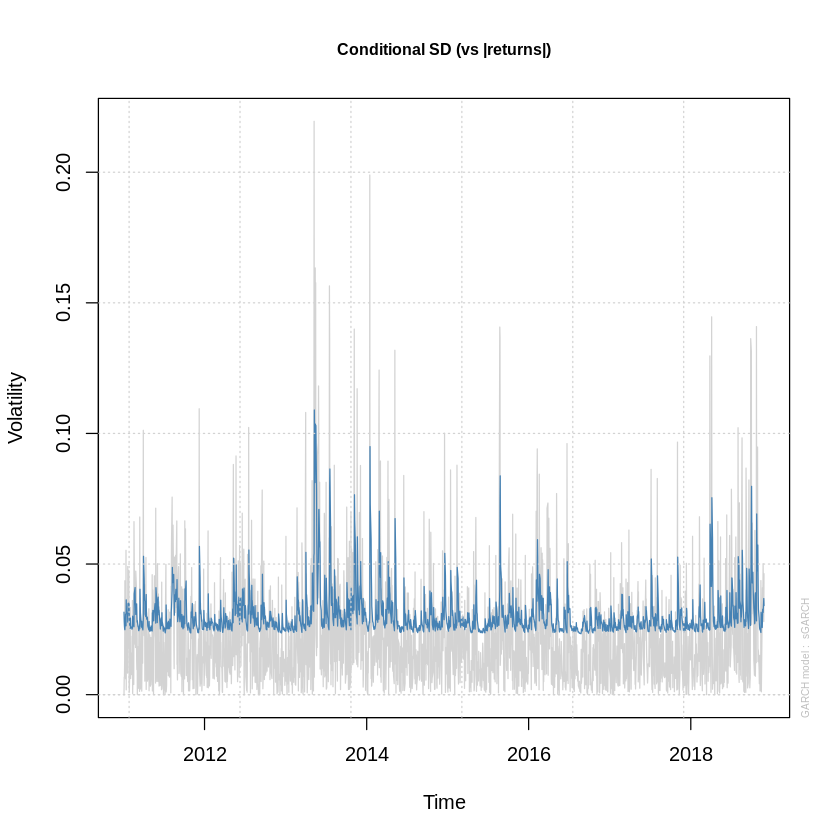

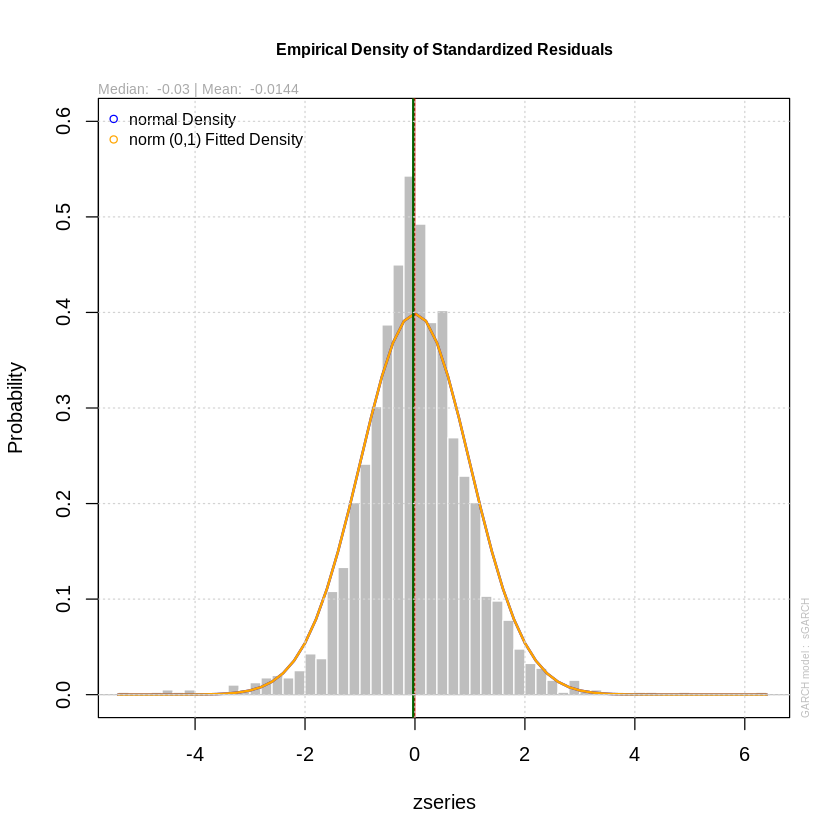

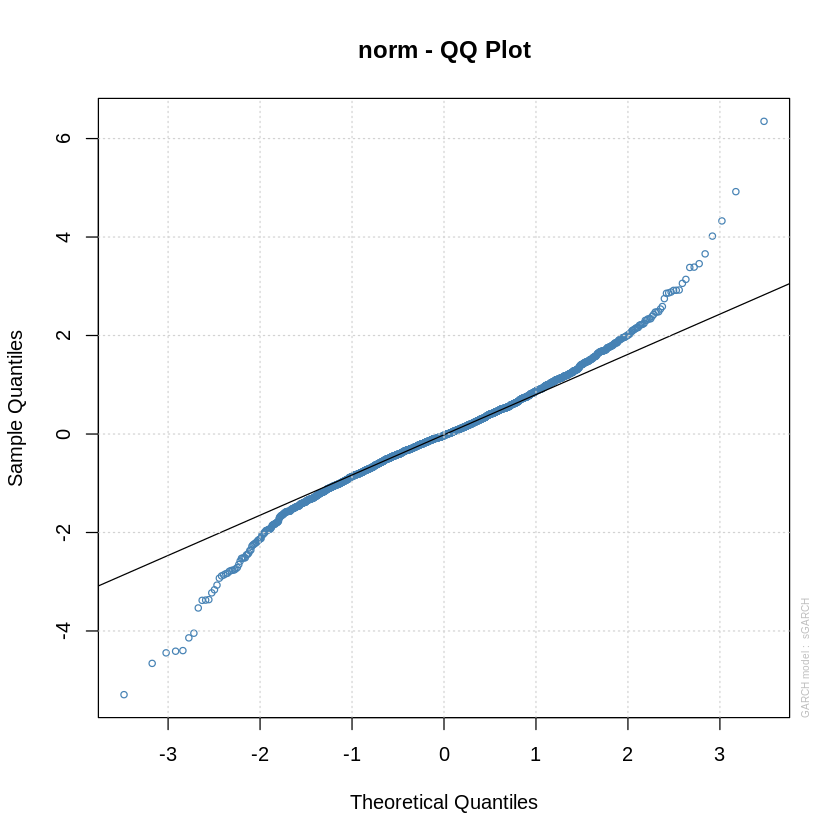

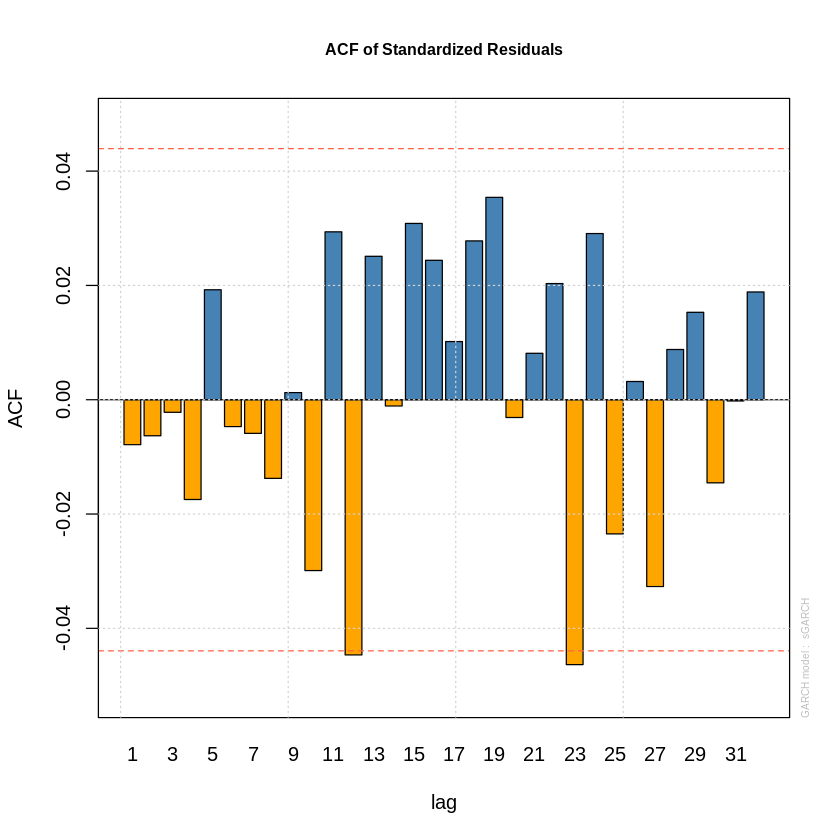

In [ ]:
for (i in c(2,3,8,9,10)){plot(garch11.fit,which = i)}

Guardamos en el objeto `tesla.tss` la serie completa para realizar el gráfico posterior con los pronósticos.

In [ ]:
tesla.tss <- xts(data$Open, order.by=as.Date(data$Date))

Creamos un objeto auxiliar

In [ ]:
#Estimacion del modelo con datos de entrenamiento 
out_of_sample <- 497
dates_out_of_sample <- tail(index(tesla.tss), out_of_sample)

Ajustamos el modelo en `garch_fit2`

In [ ]:
garch_fit2 <- ugarchfit(spec = garch11, data = sretornos, out.sample = 497)

Calculamos el pronóstico del modelo

In [ ]:
#Pronosticar los retornos logarítmicos a lo largo de toda la muestra
garch_fore <- ugarchforecast(garch_fit2, n.ahead = 1, n.roll = out_of_sample-1)
forecast_log_returns <- xts(garch_fore@forecast$seriesFor[1, ], dates_out_of_sample)
forecast_volatility <- xts(garch_fore@forecast$sigmaFor[1, ], dates_out_of_sample)

In [ ]:
#Recuperar log precios
prev_log_price <- head(tail(log(data$Open), out_of_sample+1), out_of_sample)
forecast_log_prices <- xts(prev_log_price + garch_fore@forecast$seriesFor[1, ], dates_out_of_sample)

Graficamos en la **escala original** de la acción TESLA

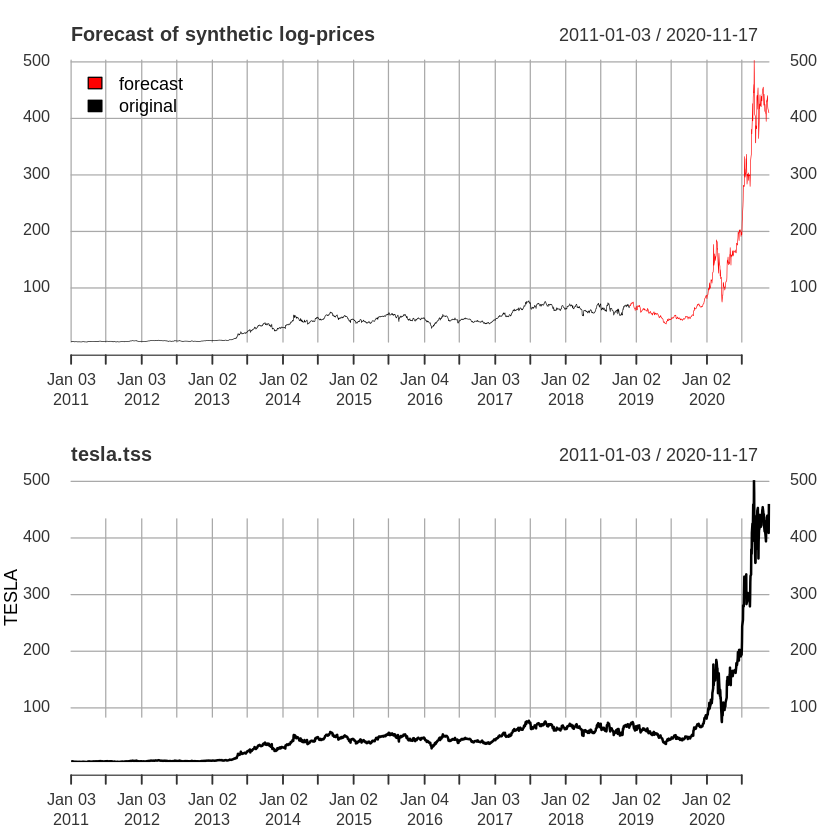

In [ ]:
par(mfrow = c(2,1))
plot(cbind("forecast" = exp(forecast_log_prices),
           "original" = tesla.ts), 
     col = c("red", "black"), lwd = c(0.5, 0.5, 2),
     main = "Forecast of synthetic log-prices", legend.loc = "topleft")
plot(tesla.tss,type='l',ylab = 'TESLA')

Vemos un excelente ajuste en los datos de validación.

#### Red Neuronal LSTM

##### Cargamos librerias básicas para el manejo de datos, gráficas y cálculos en python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Ubicamos en nuestro espacio de trabajo las bases de datos que usaremos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving TSLA.csv to TSLA (2).csv


Importamos el  Dataset de entrenamiento el cual consta de 2487 datos con información diaria de las acciones de Tesla desde el 3 de enero del 2011 hasta el 17 de noviembre del 2020

In [ ]:
nt_completa= pd.read_csv(r'TSLA.csv')

Un vistazo de la estructura de la base de datos nos muestra lo siguiente

In [ ]:
print(nt_completa.tail(300))
print(nt_completa.shape)
print(np.max(nt_completa))

            Date        Open        High  ...       Close   Adj Close    Volume
2187  2019-09-12   49.540001   50.700001  ...   49.174000   49.174000  42906000
2188  2019-09-13   49.391998   49.689999  ...   49.040001   49.040001  26565500
2189  2019-09-16   49.200001   49.486000  ...   48.562000   48.562000  23640500
2190  2019-09-17   48.493999   49.119999  ...   48.958000   48.958000  19327000
2191  2019-09-18   49.000000   49.633999  ...   48.698002   48.698002  20851000
...          ...         ...         ...  ...         ...         ...       ...
2482  2020-11-11  416.450012  418.700012  ...  417.130005  417.130005  17357700
2483  2020-11-12  415.049988  423.000000  ...  411.760010  411.760010  19855100
2484  2020-11-13  410.850006  412.529999  ...  408.500000  408.500000  19771100
2485  2020-11-16  408.929993  412.450012  ...  408.089996  408.089996  26838600
2486  2020-11-17  460.170013  462.000000  ...  441.609985  441.609985  61014500

[300 rows x 7 columns]
(2487, 7)
Date  

In [ ]:
nt_completa.sort_values('Date', ascending=True, inplace=True)

**Graficamos las variables**

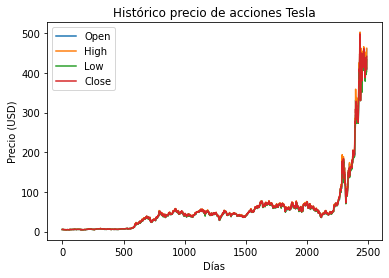

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(nt_completa["Open"])
plt.plot(nt_completa["High"])
plt.plot(nt_completa["Low"])
plt.plot(nt_completa["Close"])
plt.title('Histórico precio de acciones Tesla')
plt.ylabel('Precio (USD)')
plt.xlabel('Días')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [ ]:
print("Verificación de que no existan NAs en la base\n", nt_completa.isna().sum())

Verificación de que no existan NAs en la base
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


##### Elegimos la columna de interés: **Open**

In [ ]:
nt_processed = nt_completa.iloc[:,1:2].values

In [ ]:
len(nt_processed)

2487

Para la decisión del número de covariables se dará un primer vistazo al gráfico de la función de autocovarianza para 100 rezagos 

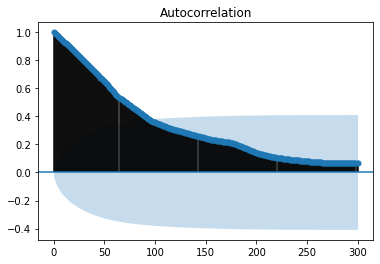

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
plot_acf(nt_processed,lags=300)
pyplot.show()

Se puede ver en la grafica de autocorrelación que existe una alta correlación en los primeros 100 rezagos, aún así, parecen se los primeros 60 rezagos los más correlacionados por lo que se decide tomar estos como autocovariables.

##### Escalamiento de los datos

Por regla general al trabajar con redes neuronales se deben normalizar o escalar los datos, en este caso utilizaremos el comando MinMaxScaler del paquete sklearn para escalar los datos entre 0 y 1 .

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

nt_training_scaled = scaler.fit_transform(nt_processed)

##### Creación de variables rezagadas

El objetivo de nuestro proyecto es poder predecir el valor de la acción de apertura de Tesla en el tiempo T basandonos en los datos de los días T-N para cualquier número de pasos N. Para nuestro caso se ha decidido utilizar N=60.

In [ ]:
features_set = []
labels = []
for i in range(60, 2487):
    features_set.append(nt_training_scaled[i-60:i, 0])
    labels.append(nt_training_scaled[i, 0])

Lo que hicimos previamente fue crear dos listas(features_set y labels). Para ello creamos un ciclo que comienza desde el registro 61 y almacena los 60 registros previos en features_set y el registro 61 en la lista "labels".

Esto se puede obsevar más claramente con el siguiente conjunto de datos

In [ ]:
features_set[0:2]

[array([0.00203301, 0.00196069, 0.00188837, 0.00202899, 0.00249908,
        0.00256738, 0.00273613, 0.00210131, 0.00208122, 0.00175578,
        0.00148659, 0.00140221, 0.00090401, 0.00053839, 0.00070312,
        0.00115311, 0.00117722, 0.00118927, 0.00124552, 0.00091204,
        0.00101651, 0.00095624, 0.00081963, 0.00066696, 0.00059464,
        0.00080356, 0.00094418, 0.00059464, 0.00059062, 0.00074731,
        0.00049419, 0.00053035, 0.00114507, 0.00062276, 0.00044196,
        0.00016071, 0.        , 0.00041383, 0.00078749, 0.00091204,
        0.00081963, 0.00108481, 0.00108481, 0.00126561, 0.00113302,
        0.00115713, 0.00106874, 0.00083169, 0.00081963, 0.00016875,
        0.00043392, 0.0005866 , 0.00056651, 0.00051026, 0.00038169,
        0.00013259, 0.00014464, 0.00026116, 0.00036964, 0.00061071]),
 array([0.00196069, 0.00188837, 0.00202899, 0.00249908, 0.00256738,
        0.00273613, 0.00210131, 0.00208122, 0.00175578, 0.00148659,
        0.00140221, 0.00090401, 0.00053839, 0.

In [ ]:
labels[0:2]

[0.0009361489842135643, 0.0019164938432183268]

Para poder usar dichos datos para nuestro entrenamientro es necesario convertir nuestra lista como una matriz numpy con el siguiente código

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)

##### División de la variable entre entrenamiento y prueba

Para nuestro caso hemos decidido utilizar el 80% de los datos como entrenamiento y el 20% como prueba. Sin embargo, como hemos reducido nuestra base de entrenamiento al omitir los 60 rezagos nuestros porcentajes también se deben ajustar.

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test=train_test_split(features_set,labels,test_size=0.2047795632, train_size=(1-0.2047795632),shuffle=False)

Con lo que obtenemos que las siguientes dimensiones para el entrenamiento y prueba

In [ ]:
print(features_train.shape)
print(features_test.shape)

print(labels_train.shape)
print(labels_test.shape)

(1930, 60)
(497, 60)
(1930,)
(497,)


##### Cambio de forma de los datos como input de la red LSTM

Por último, para moder entrenar nuestros datos, será necesario expresar nuestra matriz en formato de tres dimensiones ya que este es el formato aceptado por las redes LSTM.
*   Primera dimensión: Número de filas o registros de nuestra base de entrenamiento (1930 en nuestro caso)
*   Segunda dimensión: Número de pasos de tiempo previos (60) 
*   Tercera dimensión: Número de features, como sólo estamos trabajando **Open** nuestro indicador es 1





In [ ]:
features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[1], 1))

In [ ]:
features_train

##### Definimos el modelo LSTM

Una vez hemos adecuado nuestra base para el entrenamiento podemos proceder a la creación de nuestro modelo.
Nuestro LSTM será un modelo secuencial con cuatro capas seguido de una capa densa.

Así que empezamos importando las librerias para la construcción del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

El primer paso será inicializar la clase secuencial al modelo y posteriormente añadirle las capas LSTM y la capa densa al modelo

In [ ]:
model = Sequential()



*   `units`: Número de neuronas que deseamos en la capa.
*   `return_sequences= True` : Si se le añadiran más capas al modelo.
*   `input_shape[1,]`: El primer parametro es el número de pasos de tiempo $N$.
*   `input_shape[,2]`: El segundo parametro es el número de indicadores.



In [ ]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_train.shape[1], 1)))

Si se desea es posible añadir una capa "Dropout" la cual se utilizá para evitar el sobre ajuste de nuestro modelo, en nuestro caso se obtuvieron mejores resultados sin en el Dropout

In [ ]:
#model.add(Dropout(0.2))

Realizamos los mismos pasos para crear otras tres capas

In [ ]:
model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(units=50))
#model.add(Dropout(0.2))

y finalmente añadimos una capa densa y como solo deseamos predecir un valor dados los 60 valores previos, el valor de units=1

In [ ]:
model.add(Dense(units = 1))

##### Compilación del modelo 

El paso previo al entrenamiento es compilar el modelo

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

En este caso usamos la funcion de perdida del cuadrado medio del error y el optimizador escogido para reducir dicha función de perdida es "adam"

##### Entrenamiento

Por último, para entrenar el modelo utilizamos la función "fit" con los siguientes parámetros

Este proceso puede tradar unos minutos dependiendo la maquina que lo ejecute 

In [ ]:
history=model.fit(features_train, labels_train, epochs = 100, batch_size = 32,validation_split=0.1)

Epoch 1/100
55/55 [==============================] - 7s 124ms/step - loss: 5.4441e-04 - val_loss: 1.5682e-04
Epoch 2/100
55/55 [==============================] - 6s 106ms/step - loss: 5.3140e-05 - val_loss: 1.4791e-04
Epoch 3/100
55/55 [==============================] - 6s 109ms/step - loss: 5.7411e-05 - val_loss: 1.4862e-04
Epoch 4/100
55/55 [==============================] - 6s 107ms/step - loss: 5.5189e-05 - val_loss: 1.4630e-04
Epoch 5/100
55/55 [==============================] - 6s 111ms/step - loss: 4.8975e-05 - val_loss: 1.7246e-04
Epoch 6/100
55/55 [==============================] - 6s 106ms/step - loss: 4.6043e-05 - val_loss: 1.5106e-04
Epoch 7/100
55/55 [==============================] - 6s 105ms/step - loss: 4.6815e-05 - val_loss: 1.4569e-04
Epoch 8/100
55/55 [==============================] - 6s 105ms/step - loss: 3.8264e-05 - val_loss: 1.2982e-04
Epoch 9/100
55/55 [==============================] - 6s 109ms/step - loss: 3.5417e-05 - val_loss: 1.4514e-04
Epoch 10/100
55/55 

Para graficar la función de perdida ejecutamos el siguiente código

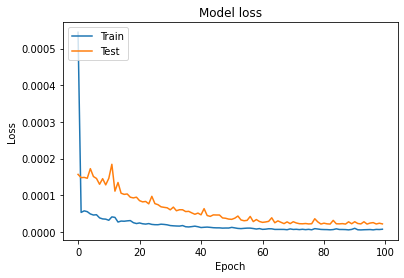

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

En la grafica anterior se nota el rapido descenso de la función de perdida, lo que nos sugiere que el modelo se esta ajustando bien a los datos y por ende, el error cuadratico medio está disminuyendo

##### Testeo de nuestro modelo LSTM

Hemos entrenado exitosamente nuestro modelo, nuestro siguiente paso será observar que tan bien se ajusta a datos que no estuvieron presentes  en el entrenamiento. En nuestro caso nuestros datos de testeo serán el valor de la apertura de las acciones de Tesla los 497 días posteriores a los datos de entrenamiento.


Como requerimos de los 60 registros previos para poder predecir en nuestro modelo, el siguiente paso es añadir nuestros 60 datos previos al primer valor de testeo

In [ ]:
test_inputs =nt_training_scaled[len(nt_training_scaled) - len(features_test) - 60:]

In [ ]:
len(features_test)

497

In [ ]:
len(test_inputs)

557

Creamos nuestro conjunto de 60 datos para los test_feature, los convertimos en matrices y los escribimos en su formato de tercera dimensión

In [ ]:
test_features = []
for i in range(60,557):
    test_features.append(test_inputs[i-60:i, 0])

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

##### Predicciones

Ya que hemos preprocesado nuestros datos de testeo los podemos usar para realizar predicciones, basta con hacer uso de la función `predict` en el modelo que creamos.

In [ ]:
predictions = model.predict(test_features)

Como los datos estuvieron escalados al entrar al modelo, su predicción también estará escalada por lo que ejecutamos la función inverse_transform como sigue

In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
label_test1=nt_processed[1990:2487]

Finalmente miremos qué tan bien está prediciendo nuestro modelo

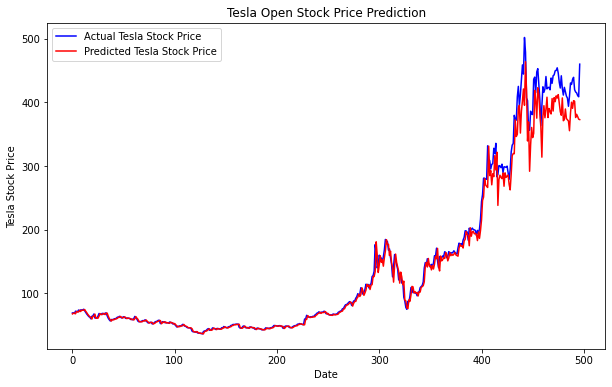

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(label_test1, color='blue', label='Actual Tesla Stock Price')
plt.plot(predictions , color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Open Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
error= mean_squared_error(label_test1,predictions)
print("El error es", error, predictions.shape, label_test1.shape)

El error es 331.0080915917755 (497, 1) (497, 1)


Podemos apreciar que el modelo logra capturar gran parte del comportamiento del modelo .

# Escogemos el mejor modelo.

Calculamos el $ECM$ para el $20\%$ de los datos de validación para el modelo $GARCH(1,1)$.

In [ ]:
sum((exp(forecast_log_prices)-data$Open[1991:2487])^2)/length(forecast_log_prices)

[1] 114.4098

| Modelo  | ECM  |
|---|---|
| $GARCH(1,1)$  | 114.4  |
|  Red Neuronal LSTM | 331.0  |


Con lo cuál concluimos que escogemos el modelo de volatilidad $GARCH(1,1)$ .